In [1]:
# For Mounting Google Drive when using Colab
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

%cd gdrive/MyDrive/h23q-data

! ls

Mounted at /content/gdrive/


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
normal_files = ['1-cloudflare-ben.csv', '2-cloudflare-ben.csv', '3-cloudflare-ben.csv', '4-cloudflare-ben.csv']
abnormal_files = [f for f in os.listdir('.') if os.path.isfile(f) and f.endswith('-cloudflare-mal.csv')]

In [6]:
selected_feature_names=['src_port', 'protocol', 'flow_duration', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_std', 'bwd_pkt_len_max',
       'bwd_pkt_len_min', 'bwd_pkt_len_mean', 'bwd_pkt_len_std',
       'fwd_header_len', 'bwd_header_len', 'flow_iat_max',
       'fwd_iat_tot', 'fwd_iat_max', 'down_up_ratio',
        'idle_max', 'idle_mean', 'idle_std',
       'fwd_pkts_b_avg', 'bwd_byts_b_avg', 'bwd_pkts_b_avg',
       'bwd_blk_rate_avg']

In [7]:
# REMOVE UNSELECTED FEATURES
df = pd.read_csv(normal_files[0])
columns_list = df.columns.tolist()
# Define columns to drop
columns_to_keep = selected_feature_names
# columns_to_drop = ['src_ip', 'dst_ip', 'timestamp']  # List of columns to drop
columns_to_drop = [c for c in columns_list if c not in columns_to_keep]

In [8]:
# Load normal class data
normal_data = []
for file in normal_files:
    df = pd.read_csv(file)
    df.drop(columns=columns_to_drop, inplace=True)  # Drop specified columns
    normal_data.append(df.values)

# Convert normal data to numpy array
normal_data = np.concatenate(normal_data)

In [9]:
normal_data.shape

(2633, 23)

In [27]:
# Split normal data into train and test sets
X_train_normal, X_test_normal = train_test_split(normal_data, test_size=0.4, random_state=42)

In [28]:
# Scale the normal data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_test_scaled = scaler.transform(X_test_normal)

In [29]:
# Convert normal data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

In [13]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
# Define the model
input_dim = X_train_tensor.shape[1]
model = Autoencoder(input_dim)

In [15]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
train_losses = []

In [17]:
X_train_tensor.shape

torch.Size([1579, 23])

In [27]:
for param_group in optimizer.param_groups:
  param_group['lr'] = 0.0002

In [18]:
# Loading Trained Model from Drive
input_dim = X_train_normal.shape[1]
model = Autoencoder(input_dim)

# Load the saved model state_dict
model.load_state_dict(torch.load('cloudflare-final.pth'))

<All keys matched successfully>

In [29]:
# Training the model
num_epochs = 3000
batch_size = 32

for epoch in range(num_epochs):
    epoch_losses = []
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        epoch_losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss_mean = np.mean(epoch_losses)
    train_losses.append(epoch_loss_mean)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss_mean:.6f}')


Epoch [1/3000], Loss: 0.000094
Epoch [2/3000], Loss: 0.000094
Epoch [3/3000], Loss: 0.000094
Epoch [4/3000], Loss: 0.000094
Epoch [5/3000], Loss: 0.000094
Epoch [6/3000], Loss: 0.000094
Epoch [7/3000], Loss: 0.000093
Epoch [8/3000], Loss: 0.000094
Epoch [9/3000], Loss: 0.000094
Epoch [10/3000], Loss: 0.000094
Epoch [11/3000], Loss: 0.000094
Epoch [12/3000], Loss: 0.000094
Epoch [13/3000], Loss: 0.000094
Epoch [14/3000], Loss: 0.000094
Epoch [15/3000], Loss: 0.000094
Epoch [16/3000], Loss: 0.000095
Epoch [17/3000], Loss: 0.000096
Epoch [18/3000], Loss: 0.000095
Epoch [19/3000], Loss: 0.000095
Epoch [20/3000], Loss: 0.000094
Epoch [21/3000], Loss: 0.000094
Epoch [22/3000], Loss: 0.000094
Epoch [23/3000], Loss: 0.000094
Epoch [24/3000], Loss: 0.000094
Epoch [25/3000], Loss: 0.000094
Epoch [26/3000], Loss: 0.000093
Epoch [27/3000], Loss: 0.000095
Epoch [28/3000], Loss: 0.000094
Epoch [29/3000], Loss: 0.000094
Epoch [30/3000], Loss: 0.000094
Epoch [31/3000], Loss: 0.000094
Epoch [32/3000], 

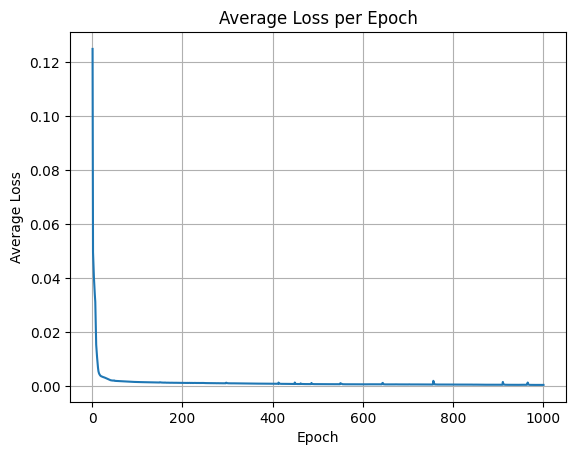

In [ ]:
# Generate Training Loss Graph

# Generate x values (epochs)
epochs = range(1, len(train_losses[:1000]) + 1)

# Plot the average loss per epoch
plt.plot(epochs, train_losses[:1000], linestyle='-')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Loss per Epoch')

# Show grid
plt.grid(True)

# Show the plot
plt.show()

In [30]:
len(train_losses)

12000

In [53]:
# Save Model to Drive
torch.save(model.state_dict(), 'cloudflare-final.pth')

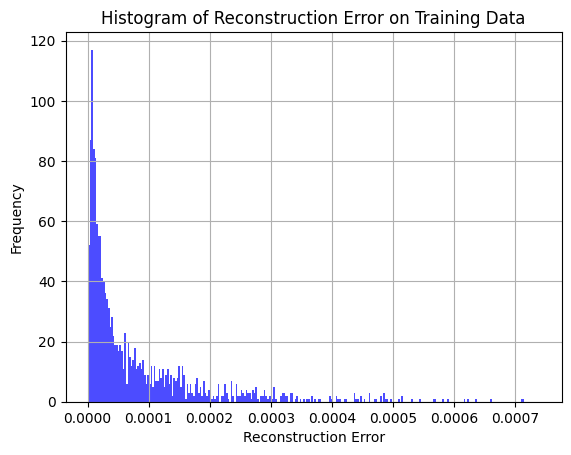

In [19]:
# Plotting reconstruction error histogram
losses = []
model.eval()
with torch.no_grad():
    for i in range(0, len(X_train_tensor)):
      inputs = X_train_tensor[i]
      outputs = model(inputs)
      loss = criterion(outputs, inputs)
      losses.append(loss.item())


threshold = 0.0
plt.hist(losses, bins=np.arange(min(losses), np.percentile(losses, 99)*1.1, (np.percentile(losses, 99)-min(losses))/250) , color='blue', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
# plt.axvline(x=threshold, color='red', linestyle='--')
plt.title('Histogram of Reconstruction Error on Training Data')
plt.grid(True)
plt.show()

In [20]:
# Calculate min, max, and 90-99th percentile reconstruction error
min_loss = np.min(losses)
max_loss = np.max(losses)
percentile_99 = np.percentile(losses, 99)

print(f"Minimum reconstruction error: {min_loss:.5f}")
print(f"Maximum reconstruction error: {max_loss:.5f}")
print(f"90th percentile of reconstruction error: {np.percentile(losses, 90):.5f}")
print(f"91th percentile of reconstruction error: {np.percentile(losses, 91):.5f}")
print(f"92th percentile of reconstruction error: {np.percentile(losses, 92):.5f}")
print(f"93th percentile of reconstruction error: {np.percentile(losses, 93):.5f}")
print(f"94th percentile of reconstruction error: {np.percentile(losses, 94):.5f}")
print(f"95th percentile of reconstruction error: {np.percentile(losses, 95):.5f}")
print(f"96th percentile of reconstruction error: {np.percentile(losses, 96):.5f}")
print(f"97th percentile of reconstruction error: {np.percentile(losses, 97):.5f}")
print(f"98th percentile of reconstruction error: {np.percentile(losses, 98):.5f}")
print(f"99th percentile of reconstruction error: {np.percentile(losses, 99):.5f}")

Minimum reconstruction error: 0.00000
Maximum reconstruction error: 0.00134
90th percentile of reconstruction error: 0.00024
91th percentile of reconstruction error: 0.00025
92th percentile of reconstruction error: 0.00027
93th percentile of reconstruction error: 0.00028
94th percentile of reconstruction error: 0.00030
95th percentile of reconstruction error: 0.00032
96th percentile of reconstruction error: 0.00037
97th percentile of reconstruction error: 0.00044
98th percentile of reconstruction error: 0.00049
99th percentile of reconstruction error: 0.00067


In [21]:
# Load abnormal class data
abnormal_data = []
for file in abnormal_files:
    df = pd.read_csv(file)
    df.drop(columns=columns_to_drop, inplace=True)  # Drop specified columns
    abnormal_data.append(df.values)

# Convert abnormal data to numpy array
abnormal_data = np.concatenate(abnormal_data)

# Scale the abnormal data
abnormal_data_scaled = scaler.transform(abnormal_data)

# Convert abnormal data to PyTorch tensor
X_abnormal_tensor = torch.tensor(abnormal_data_scaled, dtype=torch.float32)

In [22]:
X_abnormal_tensor.shape

torch.Size([5502, 23])

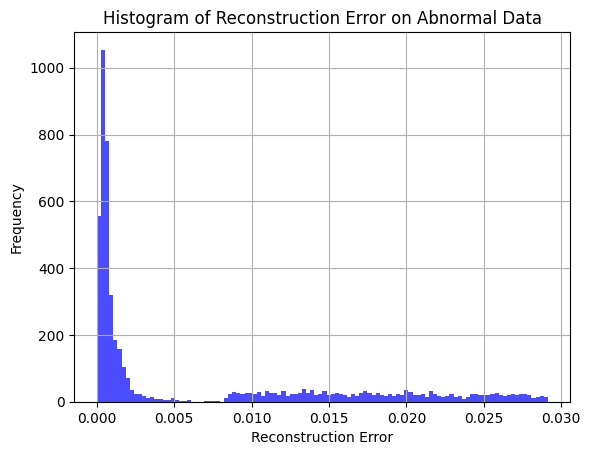

Minimum reconstruction error: 0.00000
Maximum reconstruction error: 0.30450
1th percentile of reconstruction error: 0.00004
3th percentile of reconstruction error: 0.00016


In [23]:
# Plotting reconstruction error histogram for abnormal traffic
losses = []
model.eval()
with torch.no_grad():
    for i in range(0, len(X_abnormal_tensor)):
      inputs = X_abnormal_tensor[i]
      outputs = model(inputs)
      loss = criterion(outputs, inputs)
      losses.append(loss.item())


threshold = 0.00
# plt.hist(losses, bins=np.arange(min(losses), max(losses)+0.01, (max(losses)-min(losses))/30), color='blue', alpha=0.7)
plt.hist(losses, bins=np.arange(min(losses), np.percentile(losses, 90)*1.1, (np.percentile(losses, 90)-min(losses))/100), color='blue', alpha=0.7)
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
# plt.axvline(x=threshold, color='red', linestyle='--')
plt.title('Histogram of Reconstruction Error on Abnormal Data')
plt.grid(True)
plt.show()

# Calculate min, max, and 99th percentile reconstruction error
min_loss = np.min(losses)
max_loss = np.max(losses)

print(f"Minimum reconstruction error: {min_loss:.5f}")
print(f"Maximum reconstruction error: {max_loss:.5f}")
print(f"1th percentile of reconstruction error: {np.percentile(losses, 1):.5f}")
print(f"3th percentile of reconstruction error: {np.percentile(losses, 3):.5f}")

In [30]:
X_abnormal_tensor.shape[0]

5502

In [31]:
X_test_tensor.shape[0]

1054

In [32]:
# Shuffle and select specific number of data points from X_abnormal_tensor and X_normal_tensor
num_samples_abnormal = X_abnormal_tensor.shape[0]  # Number of samples to select from abnormal data
num_samples_normal = X_test_tensor.shape[0]  # Number of samples to select from normal data


In [33]:
from torch.utils.data import random_split
# Shuffle and select specific number of data points from X_abnormal_tensor
abnormal_subset = X_abnormal_tensor[torch.randperm(X_abnormal_tensor.size(0))[:num_samples_abnormal]]

# Shuffle and select specific number of data points from X_test_tensor_normal
normal_subset = X_test_tensor[torch.randperm(X_test_tensor.size(0))[:num_samples_normal]]

# Combine abnormal and normal subsets for testing
X_test_tensor_subset = torch.cat((normal_subset, abnormal_subset), dim=0)

# True labels for the subset (0 for normal, 1 for abnormal)
test_labels = torch.cat((torch.zeros(num_samples_normal), torch.ones(num_samples_abnormal)), dim=0)

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Classify anomalies in test data subset
model.eval()
test_errors = []
with torch.no_grad():
    for i in range(0, len(X_test_tensor_subset)):
      inputs = X_test_tensor_subset[i]
      outputs = model(inputs)
      loss = criterion(outputs, inputs)
      test_errors.append(loss.item())

In [35]:
# Get best threshold
# Convert errors to numpy array
test_errors = np.array(test_errors)

# Define a range of threshold values to try
threshold_values = np.linspace(0.0000, 0.001, num=2500)

# Evaluate each threshold value on the test st
best_threshold = None
best_metric = 0.0  # Initialize the best metric value
for threshold in threshold_values:
    # Apply the threshold to classify examples as normal or anomaly
    predictions = (test_errors > threshold).astype(int)
    # Evaluate the classification performance using a metric of your choice
    metric = accuracy_score(test_labels, predictions)  # Example: Accuracy
    # Update the best threshold if the current metric is better
    if metric > best_metric:
        best_metric = metric
        best_threshold = threshold

print("Best Threshold:", best_threshold)
print("Best Metric (e.g., Accuracy):", best_metric)

Best Threshold: 0.00015406162464985996
Best Metric (e.g., Accuracy): 0.9281574130567419


In [36]:
# Print Classification Metrics for best threshold
threshold = best_threshold
# Convert errors to numpy array
test_errors = np.array(test_errors)

# Now you can use the best threshold to classify examples on the test set
test_predictions = (test_errors > threshold).astype(int)
print("Test Accuracy:", accuracy_score(test_labels, test_predictions))
print("Classification Report:")
print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.9281574130567419
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.70      0.76      1054
         1.0       0.94      0.97      0.96      5502

    accuracy                           0.93      6556
   macro avg       0.89      0.84      0.86      6556
weighted avg       0.93      0.93      0.93      6556



In [37]:
atk_dict = {
    1: 'HTTP-Flood',
    2: 'Fuzzing',
    3: 'HTTP-Loris',
    4: 'HTTP-Stream',
    5: 'QUIC-Flood',
    6: 'QUIC-Loris',
    7: 'QUIC-enc',
    8: 'HTTP-Smuggle',
    9: 'HTTP2-Concurrent',
    10: 'HTTP2-Pause'
}

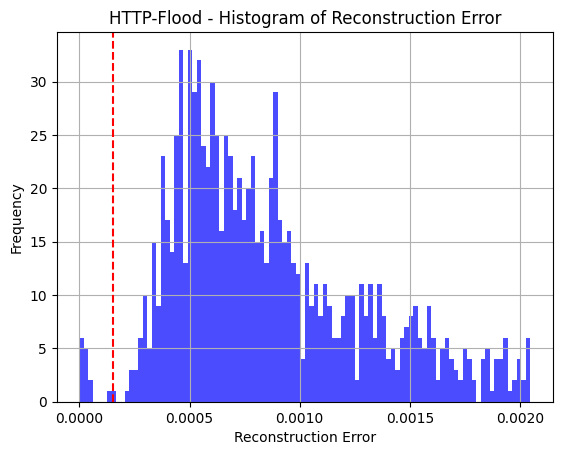

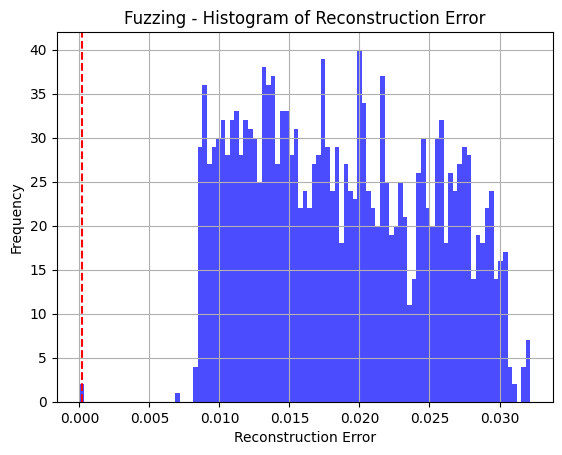

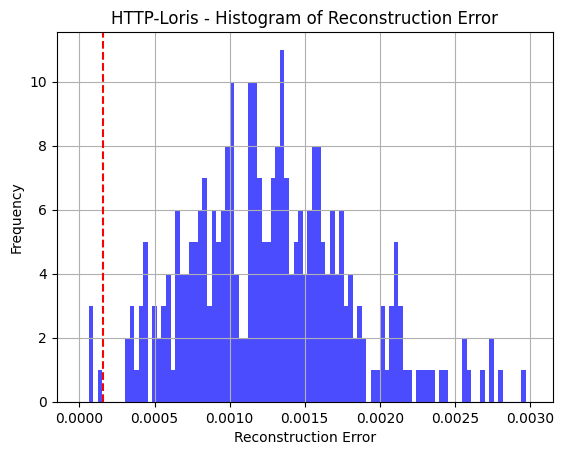

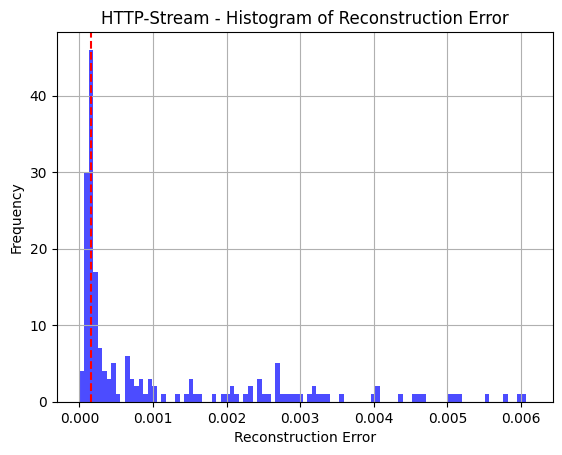

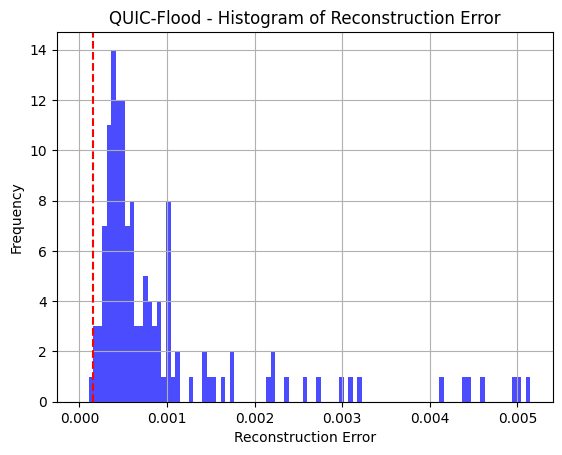

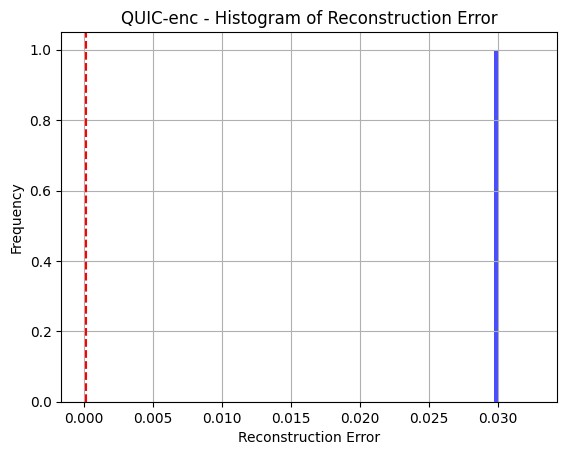

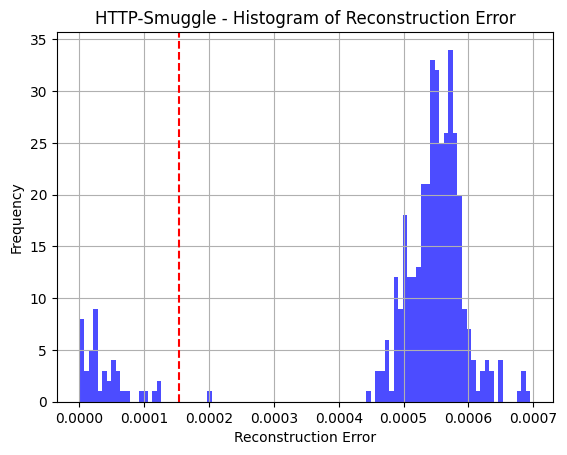

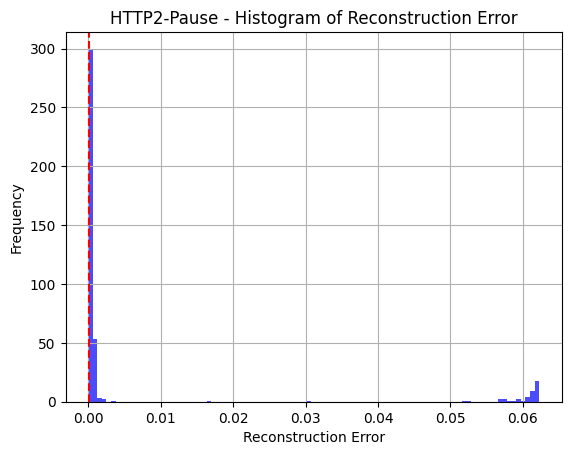

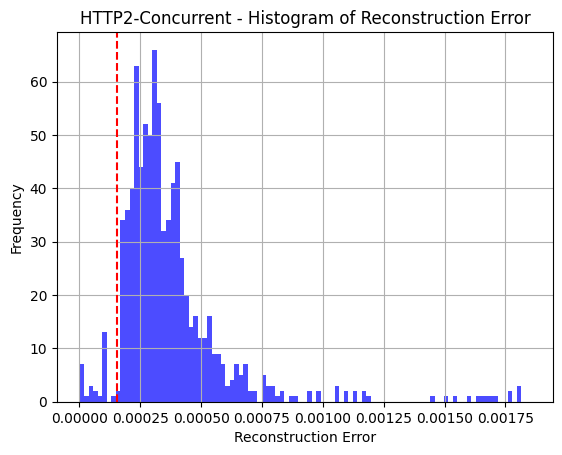

In [38]:
# Generate Reconstruction Error Graph for Each Attack
# Load abnormal class data

r = {}
for file in abnormal_files:
  abnormal_data = []
  df = pd.read_csv(file)
  df.drop(columns=columns_to_drop, inplace=True)  # Drop specified columns
  abnormal_data.append(df.values)

  attack_name = atk_dict[int(file.split('-')[0])]

  # Convert abnormal data to numpy array
  abnormal_data = np.concatenate(abnormal_data)
  # Scale the abnormal data
  abnormal_data_scaled = scaler.transform(abnormal_data)
  # abnormal_pca = pca.transform(abnormal_data_scaled)
  # Convert abnormal data to PyTorch tensor
  X_abnormal_tensor = torch.tensor(abnormal_data_scaled, dtype=torch.float32)
  # X_abnormal_tensor = torch.tensor(abnormal_pca, dtype=torch.float32)
  X_abnormal_tensor.shape

  # FULL REPEAT FOR ABNORMAL
  # Plotting reconstruction error histogram
  losses = []
  detected = 0
  model.eval()
  with torch.no_grad():
      for i in range(0, len(X_abnormal_tensor)):
        inputs = X_abnormal_tensor[i]
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        losses.append(loss.item())

  for l in losses:
    if l >= threshold:
      detected +=1
  r[attack_name]=detected/len(losses)

  try:
    plt.hist(losses, bins=np.arange(0, np.percentile(losses, 90)*1.1, (np.percentile(losses, 90)*1.1-0)/100), color='blue', alpha=0.7)
    plt.axvline(x=best_threshold, color='red', linestyle='--')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title(f'{attack_name} - Histogram of Reconstruction Error')
    plt.grid(True)
    plt.show()
  except:
    pass


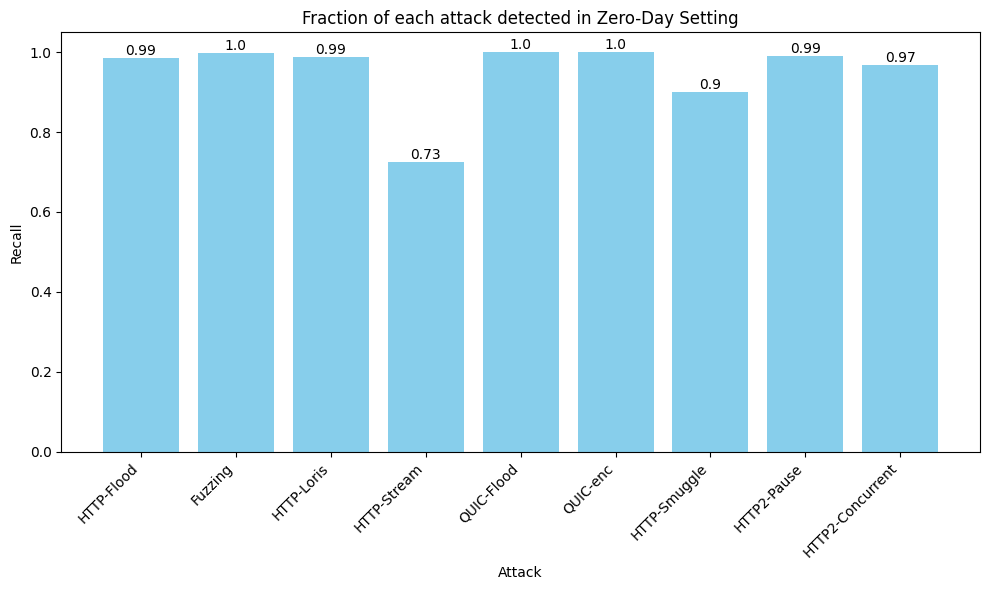

In [39]:
import matplotlib.pyplot as plt

data = r
filenames = list(data.keys())
values = list(data.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(filenames, values, color='skyblue')
plt.xlabel('Attack')
plt.ylabel('Recall')
plt.title('Fraction of each attack detected in Zero-Day Setting')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Displaying values on top of each bar
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 2), ha='center', va='bottom')

plt.show()